# Avoiding Bubbles with VolQ Risk-Off Recommendation
---
Here we use the same LPPLS indicator but we substitute the @VolitlityQ Risk Off portfolio. Outlined here:

- Long: VXX IEI SHY SHV BIL GLD UUP FXF FXY 
- Short: TLT EMB DBC GSG GDX REM VNQ IWM DIA SPY QQQ EEM VGK HYG LQD IGSB BITO

With the Caveat:
Some of these assets classes should NOT be traded via ETFs.

In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
from lppls import lppls
import numpy as np
from os.path import exists
import pandas as pd
import time
import yfinance as yf

from utils import plotting as plt_u # import utility functions for plotting 

START = '1997-05-30'
END = '2021-11-24'
LOOKBACK = 21 * 6 # 21 days in a trading month
UNIVERSE_CSV = 'data/universeVolQ.csv'
LPPLS_CONF_CSV = 'data/confidence.csv'
CPU_CORES = max(1, cpu_count() // 2)  # only let the LPPLS number cruncher use half the available cores
POS_BUBBLE_THRESHOLD = 0.08
NEG_BUBBLE_THRESHOLD = 0.02

## Fetching Universe Data (Yahoo! Finance)

Yahoo! Finance computes an Adjusted Closing price that factors in all splits and dividends. 
https://help.yahoo.com/kb/SLN28256.html

In [2]:
tickers = ['TLT', 'VTI', 'VTV', 'VBR', 'AGG', '^VIX', '^VIX3M', 'SPY'] 

shorts = ['TLT', 'EMB', 'IWM', 'DIA', 'SPY', 'EEM', 'VGK', 'REM', 'VNQ', 'DMC', 'GSG', 'GDX', 'BITO', 'LQD', 'IGSB', 'HYG']
longs = ['IEI', 'SHY', 'BIL', 'UUP', 'FXF', 'FXY', 'VXX', 'GLD']

portfolioVolQ = longs + shorts

portfolioVolQwReturnString = [f'{col} Returns' for col in portfolioVolQ]

if not exists(UNIVERSE_CSV):
    print('fetch data from Yahoo! Finance')
    adj_close_list = []
    for ticker in tickers + portfolioVolQ:
        ticker_module = yf.Ticker(ticker)
        data = yf.download(ticker, start=START, end=END)
        adj_close = data['Adj Close']
        adj_close.rename(f'{ticker} Adj Close', inplace=True)
        adj_close_list.append(adj_close)
    # combine all dataframes into a single dataframe
    df_adj_close = pd.concat(adj_close_list, axis=1)
    df_adj_close.to_csv(UNIVERSE_CSV)
else:
    print('load data from cache')
    df_adj_close = pd.read_csv(UNIVERSE_CSV, index_col='Date', parse_dates=True)

load data from cache


In [3]:
research_factors = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True)
factors_df = research_factors[START:END]  # filter rows by backtest dates

# convert the annulaized risk-free rate of return (average over backtest lifetime) to daily
RISK_FREE_RATE = factors_df['RF'].mean()/252
print('RISK_FREE_RATE = {:.5f}%'. format(RISK_FREE_RATE * 100))

RISK_FREE_RATE = 0.00292%


## Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns

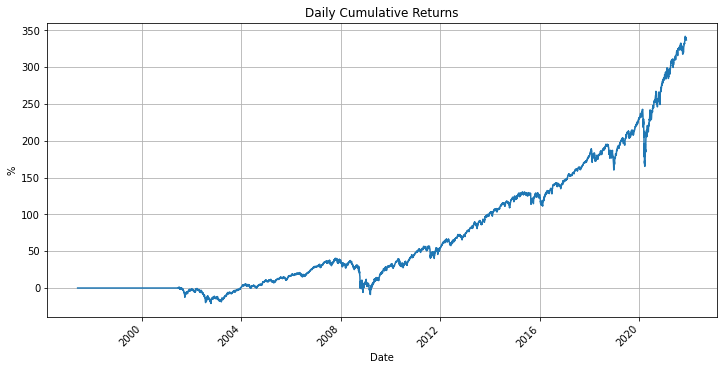

Benchmark Cumulative Returns: 336.95%


In [4]:
# get daily returns and change col names
df_pct_change = df_adj_close.pct_change().fillna(0)
df_pct_change.columns = [col.replace(' Adj Close', ' Returns') for col in df_pct_change.columns]

# call it df_D, D for Daily
df_D = df_pct_change

# create a 60/40 benchmark to compare portfolio returns against through out analysis.
df_D['Benchmark Returns'] = (
    (0.6 * df_D['VTI Returns']) + (0.4 * df_D['AGG Returns'])
)
# df_D['Benchmark Returns'] = (df_D['SPY Returns'])

# visualize the portfolio v benchmark
(((1+df_D['Benchmark Returns']).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='Daily Cumulative Returns'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
benchmark_cumulative_return = round(((1+df_D['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

## Construct Bubble Portfolio
---

In [5]:
# convert Date to ordinal, that's what the LPPLS model wants - it's a neat trick for curve-fitting with time-series
time_ord = [pd.Timestamp.toordinal(t1) for t1 in df_adj_close.index]

# create list of observation data
price = np.log(df_adj_close['VTI Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time_ord, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the VTI data
lppls_model = lppls.LPPLS(observations=observations)

load LPPLS conf scores from cache


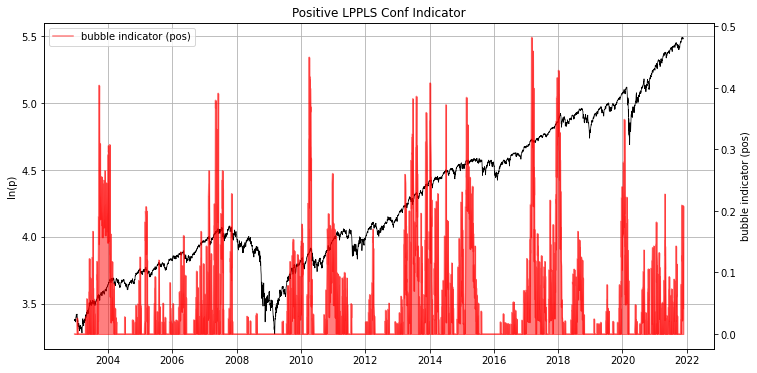

In [6]:
# compute the indicators and cache the result
if not exists(LPPLS_CONF_CSV):
    print('compute LPPLS conf scores fresh')
    # compute the confidence indicator
    res = lppls_model.mp_compute_nested_fits(
        workers=CPU_CORES,
        window_size=126*3, 
        smallest_window_size=21, 
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
        # filter_conditions_config={} # not implemented in 0.6.x
    )
    res_df = lppls_model.compute_indicators(res)
    res_df['time'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
    res_df.set_index('time', inplace=True)
    res_df.to_csv(LPPLS_CONF_CSV)
else:
    print('load LPPLS conf scores from cache')
    res_df = pd.read_csv(LPPLS_CONF_CSV, index_col='time', parse_dates=True)
    
# visualize the conf indicator   
plt_u.plot_pos_confidence_indicators(res_df)

Next we want to use this info to weight our portfolio. A simple rule could be to reduce equity exposure to 0% across the entire portfolio when the bubble confidence indicator exceeds a threshold.

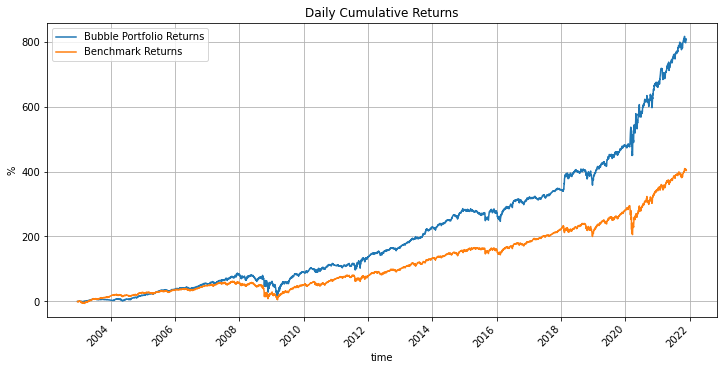

Bubble Portfolio Cumulative Returns: 807.04%
Benchmark Cumulative Returns: 403.42%


In [7]:
pos_conf_df = res_df.drop(['price', '_fits'], axis=1)
bubble_portfolio_df = pos_conf_df.join(df_D)

bubble_portfolio_df['conf'] = bubble_portfolio_df['pos_conf'] - bubble_portfolio_df['neg_conf']

# prevent lookahead bias: use yesterday's conf score today 
bubble_portfolio_df['conf'] = bubble_portfolio_df['conf'].shift(2)
bp_df = bubble_portfolio_df
# # group pos_conf by month and take the mean, 
# # @TODO: it would be better to weight most recent observations heavier
# conf_M = bubble_portfolio_df['conf'].groupby(pd.Grouper(freq='M')).mean() 

# # reintegrate monthly data to bubble_portfolio_df and forward fill the indicator, 
# # the previous month's mean pos_conf will determine what we do all next month
# bp_df = bubble_portfolio_df.join(conf_M.rename('conf_M', inplace=True))
# bp_df['conf_M'] = bp_df['conf_M'].fillna(method='ffill').fillna(0)

# simulate short returns
bp_df2 = bp_df.copy()
for col in shorts:
    bp_df2[f'{col} Returns'] = bp_df2[f'{col} Returns'] * -1

# construct a new portfolio with bubble weights...
conditions = [
    (bp_df['conf'] >= POS_BUBBLE_THRESHOLD), 
    ((bp_df['conf'] < POS_BUBBLE_THRESHOLD) & (bp_df['conf'] > -NEG_BUBBLE_THRESHOLD)),  
    (bp_df['conf'] <= -NEG_BUBBLE_THRESHOLD)]
values = [
    (   # ⬇️ Risk Off
        bp_df2[portfolioVolQwReturnString].mean(axis='columns')
    ),( # ⬇️ Equal Weight
        (0.2 * bp_df['VTI Returns']) \
        + (0.2 * bp_df['VTV Returns']) \
        + (0.2 * bp_df['VBR Returns']) \
        + (0.2 * bp_df['AGG Returns']) \
        + (0.2 * bp_df['TLT Returns']) \
    ),( # ⬇️ Risk On
        (0.333 * bp_df['VTI Returns']) \
        + (0.333 * bp_df['VTV Returns']) \
        + (0.333 * bp_df['VBR Returns']) \
        + (0.0 * bp_df['AGG Returns']) \
        + (0.0 * bp_df['TLT Returns']) \
    )
]
bp_df['Bubble Portfolio Returns'] = np.select(conditions, values)
bp_df['Allocation'] = np.select(conditions, ['risk-off', 'equal-weight', 'risk-on'])

# visualize the portfolio v benchmark
(((1+bp_df[['Bubble Portfolio Returns', 'Benchmark Returns']]).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='Daily Cumulative Returns'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
portfolio_cumulative_return = round(((1+bp_df['Bubble Portfolio Returns']).cumprod()[-1]-1)*100, 2)
print(f'Bubble Portfolio Cumulative Returns: {portfolio_cumulative_return}%')
benchmark_cumulative_return = round(((1+bp_df['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

In [8]:
bp_df

,pos_conf,neg_conf,TLT Returns,VTI Returns,VTV Returns,VBR Returns,AGG Returns,^VIX Returns,^VIX3M Returns,SPY Returns,...,GSG Returns,GDX Returns,BITO Returns,LQD Returns,IGSB Returns,HYG Returns,Benchmark Returns,conf,Bubble Portfolio Returns,Allocation
time,,,,,,,,,,,,,,,,,,,,,
2002-12-18,0.000000,0.0,0.007803,-0.014266,0.000000,0.000000,0.000000,0.061140,0.000000,-0.011557,...,0.000000,0.000000,0.000000,0.005040,0.000000,0.000000,-0.008559,NaN,0.000000,0
2002-12-19,0.000000,0.0,0.008896,-0.006100,0.000000,0.000000,0.000000,0.067868,0.000000,-0.007127,...,0.000000,0.000000,0.000000,0.006407,0.000000,0.000000,-0.003660,NaN,0.000000,0
2002-12-20,0.000000,0.0,0.000687,0.011673,0.000000,0.000000,0.000000,-0.115856,0.000000,0.014269,...,0.000000,0.000000,0.000000,0.000277,0.000000,0.000000,0.007004,0.000000,0.002472,equal-weight
2002-12-23,0.000000,0.0,0.000229,0.000382,0.000000,0.000000,0.000000,-0.019094,0.000000,0.000333,...,0.000000,0.000000,0.000000,0.000184,0.000000,0.000000,0.000229,0.000000,0.000122,equal-weight
2002-12-24,0.000000,0.0,0.005606,-0.004778,0.000000,0.000000,0.000000,0.011069,0.000000,-0.007443,...,0.000000,0.000000,0.000000,0.002122,0.000000,0.000000,-0.002867,0.000000,0.000166,equal-weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,0.142857,0.0,0.007925,-0.004119,-0.004478,-0.009014,0.002371,0.045205,0.032536,-0.002429,...,-0.013009,0.007874,0.012297,0.004023,0.000555,-0.001037,-0.001523,0.155556,0.001891,risk-off
2021-11-18,0.176471,0.0,0.003761,0.001572,-0.003737,-0.000926,0.000876,0.028054,0.014829,0.003396,...,0.003438,-0.009259,-0.040837,0.002268,0.000369,-0.000807,0.001293,0.148148,0.003651,risk-off
2021-11-19,0.088889,0.0,0.010558,-0.002849,-0.009585,-0.010140,0.001926,0.018192,0.000913,-0.001788,...,-0.015420,-0.016647,-0.002695,0.003771,-0.000554,-0.000808,-0.000939,0.142857,0.005858,risk-off


Nice! We now outperform the benchmark and we were able to partially avoid the largest drawdown! Avoiding this drawdown is fascinating because the bubble indicator, which only operates on historical price data (i.e., endogenous data), seems to be able to predict the COVID crash of February 2020 - a seemingly exogenous event. I recall a preprint that looked at this issue specifically: https://arxiv.org/pdf/2101.03625.pdf. Their finding was that the crash could mostly be described endogenously, which is quiet counterintuitive. Nonetheless, our backtest seems to corroborate this. Neat.

Below are the new drawdown stats for the bubble portfolio. The max drawdown was reduced from ~26% to ~12%.

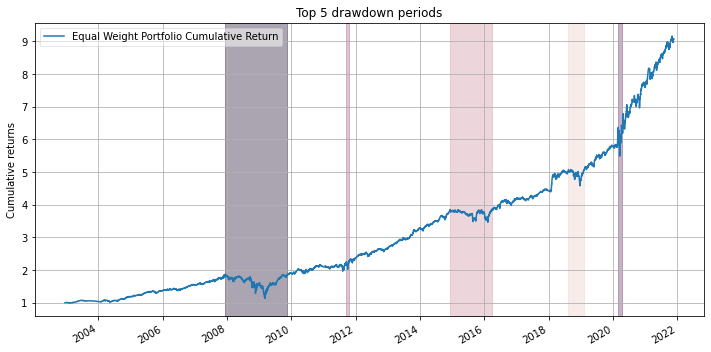

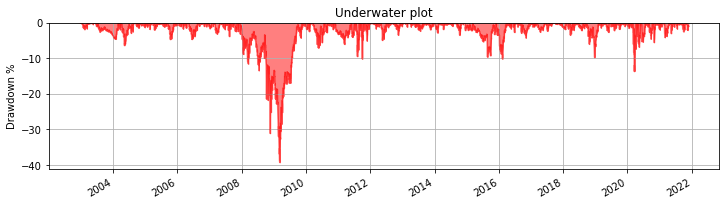

In [9]:
plt_u.plot_drawdown_periods(bp_df['Bubble Portfolio Returns'])
plt_u.plot_drawdown_underwater(bp_df['Bubble Portfolio Returns'])

If we wanted to, we could try to optimize the bubble threshold value by looking at the distribution of values. 

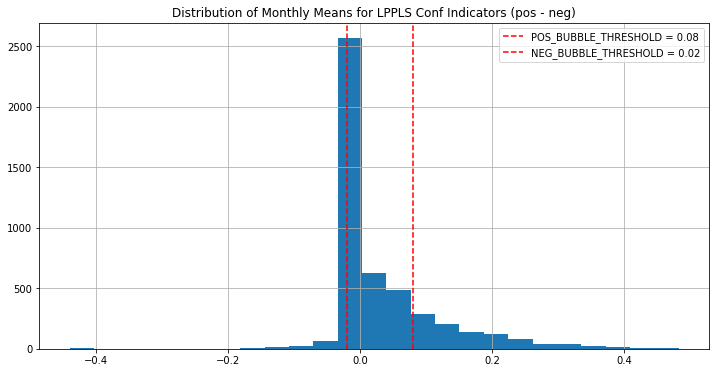

In [10]:
plt.figure(figsize=(12,6))
plt.hist(bp_df['conf'], bins=25)
plt.axvline(POS_BUBBLE_THRESHOLD, color='red', ls='--', label=f'POS_BUBBLE_THRESHOLD = {POS_BUBBLE_THRESHOLD}')
plt.axvline(-NEG_BUBBLE_THRESHOLD, color='red', ls='--', label=f'NEG_BUBBLE_THRESHOLD = {NEG_BUBBLE_THRESHOLD}')
plt.title('Distribution of Monthly Means for LPPLS Conf Indicators (pos - neg)')
plt.legend()
plt.grid()
plt.show()

## Backtest Performance Summary Statistics
---

Benchmark Portfolio Sharpe Ratio (Since Inception): 0.55
Bubble Portfolio Sharpe Ratio (Since Inception): 0.9


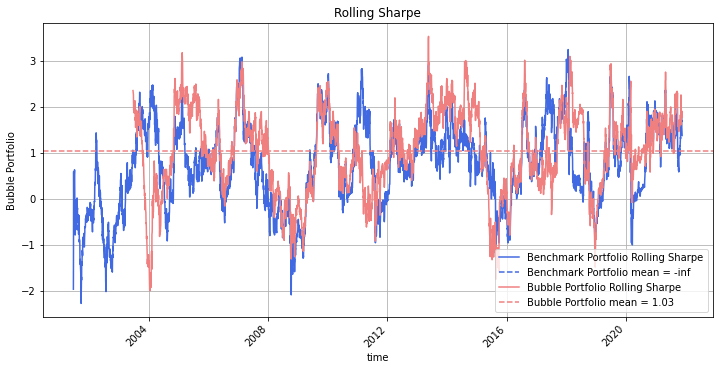

In [12]:
plt_u.plot_sharpe([
    (
        df_D['Benchmark Returns'], 
        RISK_FREE_RATE, 
        df_D['Benchmark Returns'].std(), 
        'Benchmark Portfolio',
        'royalblue',
    ), (
        bp_df['Bubble Portfolio Returns'], 
        RISK_FREE_RATE, 
        bp_df['Bubble Portfolio Returns'].std(), 
        'Bubble Portfolio',
        'lightcoral',
    )
])